# Importing Libraries

In [7]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from glob import glob
from tqdm import tqdm_notebook
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Setting dataset path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# train_dir = '/content/drive/My Drive/Colab Notebooks/training'
covid = '/content/drive/My Drive/Colab Notebooks/COVID-19 Detector/chest/Chest_COVID/'
covid_file = glob(covid+'/*')

In [4]:
# validation_dir = '/content/drive/My Drive/Colab Notebooks/test'
noncovid = '/content/drive/My Drive/Colab Notebooks/COVID-19 Detector/chest/Chest_NonCOVID'
noncovid_file = glob(noncovid+'/*')

In [5]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_file)):
    image = cv2.imread(covid_file[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    covid_images.append(image)
    covid_labels.append('Chest_COVID')
for i in range(len(noncovid_file)):
    image = cv2.imread(noncovid_file[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    noncovid_images.append(image)
    noncovid_labels.append('Chest_NonCOVID')

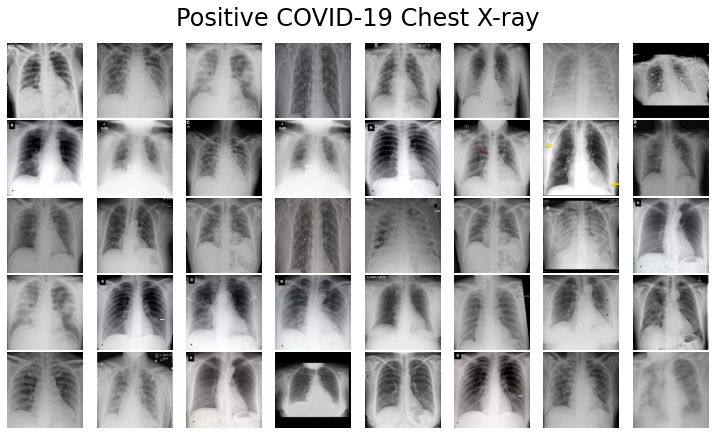

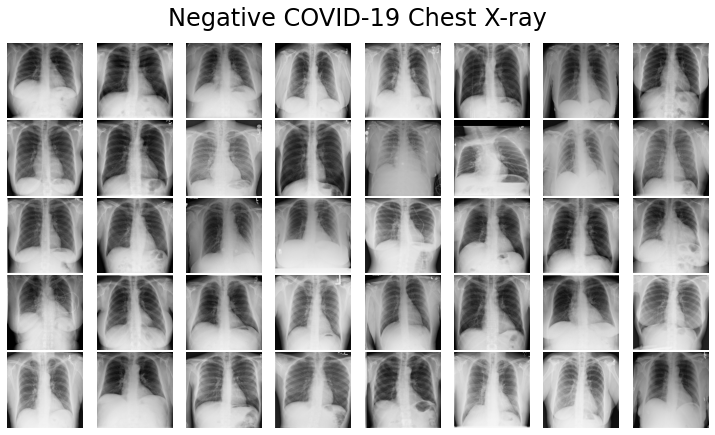

In [8]:
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

# Building Model

## Base Model

#### Loading pre-trained model: MobileNetV2

In [9]:
IMG_SHAPE = (224, 224, 3)

In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=True, weights='imagenet')

14540800/14536120 [==============================] - 0s 0us/step


In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

#### Freezing the base model

In [12]:
base_model.trainable=False

## Custom Head for network

In [13]:
prediction_layer = tf.keras.layers.Dense(units=2, activation='sigmoid')(base_model.output)

# Defining the model

In [14]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

# Compiling model

In [16]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss=['binary_crossentropy'], metrics=['accuracy'])

# Creating Data Generator

Resizing image

In [17]:
data_gen_train = ImageDataGenerator(rescale=1/255.,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True,
                                    zoom_range = 0.1
                                    )
data_gen_valid = ImageDataGenerator(rescale=1/255.,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True,
                                    zoom_range = 0.1)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

In [19]:
# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

# Training the model

In [20]:
# model.fit_generator(train_generator, validation_data=valid_generator, epochs=10)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32)

Epoch 1/200
23/23 [==============================] - 2s 96ms/step - loss: 0.6940 - accuracy: 0.4073 - val_loss: 0.6937 - val_accuracy: 0.3966
Epoch 2/200
23/23 [==============================] - 1s 43ms/step - loss: 0.6937 - accuracy: 0.4045 - val_loss: 0.6934 - val_accuracy: 0.4190
Epoch 3/200
23/23 [==============================] - 1s 42ms/step - loss: 0.6935 - accuracy: 0.4087 - val_loss: 0.6932 - val_accuracy: 0.4469
Epoch 4/200
23/23 [==============================] - 1s 43ms/step - loss: 0.6932 - accuracy: 0.4228 - val_loss: 0.6930 - val_accuracy: 0.4358
Epoch 5/200
23/23 [==============================] - 1s 42ms/step - loss: 0.6930 - accuracy: 0.4593 - val_loss: 0.6928 - val_accuracy: 0.4749
Epoch 6/200
23/23 [==============================] - 1s 43ms/step - loss: 0.6928 - accuracy: 0.5084 - val_loss: 0.6926 - val_accuracy: 0.4972
Epoch 7/200
23/23 [==============================] - 1s 43ms/step - loss: 0.6926 - accuracy: 0.5351 - val_loss: 0.6924 - val_accuracy: 0.5698
Epoch 

# Transfer Learning model evaluation

In [21]:
valid_loss, valid_accuracy = model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 27ms/step - loss: 0.6669 - accuracy: 0.6034


In [22]:
print('Accuracy after transfer learning = {}'.format(valid_accuracy))

Accuracy after transfer learning = 0.6033519506454468


# Fine Tuning

In [23]:
base_model.trainable=True

In [24]:
print('No of layers in the base model = {}'.format(len(base_model.layers)))

No of layers in the base model = 157


In [25]:
fine_tune_at = 100

Freeze all layers upto 100

In [26]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

compiling the model for fine tuning

In [27]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [29]:
pip install livelossplot

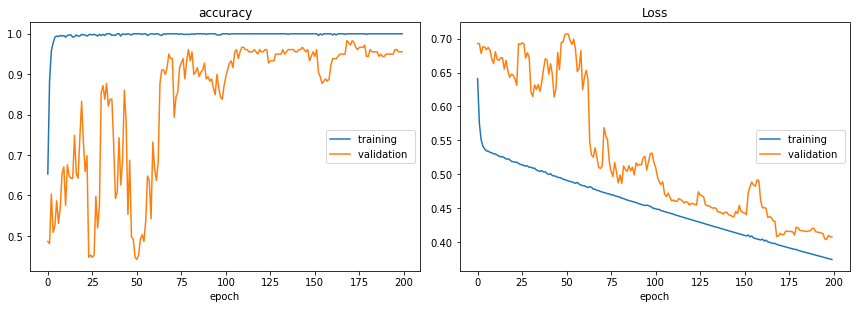

accuracy
	training         	 (min:    0.653, max:    1.000, cur:    1.000)
	validation       	 (min:    0.441, max:    0.983, cur:    0.955)
Loss
	training         	 (min:    0.374, max:    0.641, cur:    0.374)
	validation       	 (min:    0.404, max:    0.707, cur:    0.407)
23/23 [==============================] - 2s 77ms/step - loss: 0.3740 - accuracy: 1.0000 - val_loss: 0.4074 - val_accuracy: 0.9553


In [32]:
from livelossplot import PlotLossesKerasTF
import tensorflow
chkpt = tensorflow.keras.callbacks.ModelCheckpoint('model', monitor = 'val_accuracy', verbose = 1, save_best_only = True)
tensorboard = tensorflow.keras.callbacks.TensorBoard(log_dir = 'logs/mob1')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32,callbacks = [PlotLossesKerasTF()])

## Evaluating fine tuned model

In [33]:
valid_loss, valid_accuracy = model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 35ms/step - loss: 0.4074 - accuracy: 0.9553


In [34]:
print('Validation accuracy after fine tuning = {}'.format(valid_accuracy))

Validation accuracy after fine tuning = 0.9553072452545166


# Converting model to tflite

In [35]:
savedModel = "exp_saved_model"
tf.saved_model.save(model, savedModel)
converter = tf.lite.TFLiteConverter.from_saved_model(savedModel)
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'
with open(tflite_model_file, 'wb') as f:
  f.write(tflite_model)
model.save('model.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: exp_saved_model/assets


In [36]:
m=tf.keras.models.load_model('model.h5')

In [37]:
labels = ['Covid-19','Normal']
with open('labels.txt', 'w') as f:
  f.write('\n'.join(labels))

In [38]:
from sklearn.metrics import precision_score, recall_score

In [39]:
y_pred = model.predict(X_test)

In [40]:
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95        78
           1       0.98      0.94      0.96       101

    accuracy                           0.96       179
   macro avg       0.95      0.96      0.95       179
weighted avg       0.96      0.96      0.96       179



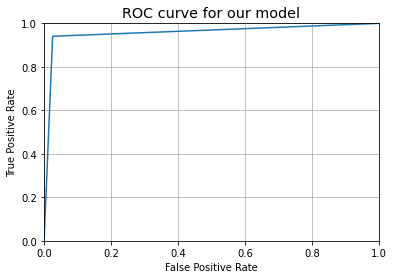

In [46]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Confusion Matrix without Normalization


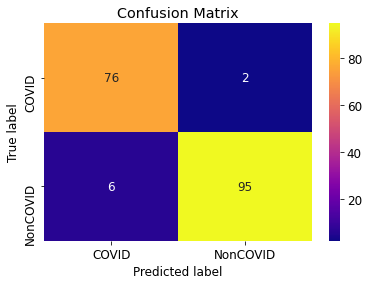

Confusion Matrix with Normalized Values


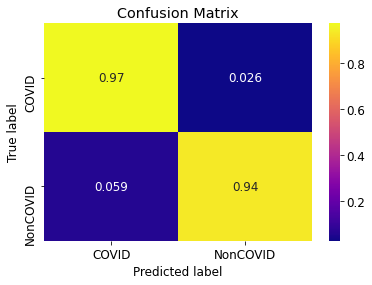

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(normalize):
    classes = ['COVID','NonCOVID']
    tick_marks = [0.5,1.5]
    cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
    sns.heatmap(cn,cmap='plasma',annot=True)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

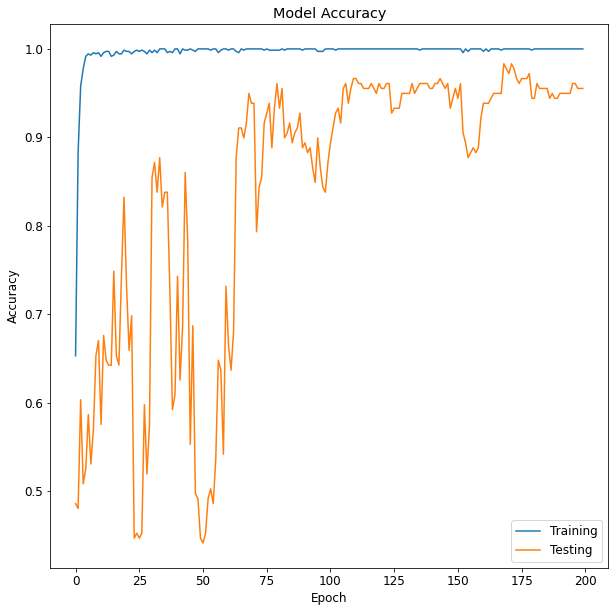

In [50]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('mobilenet_accuracy.png')
plt.show()

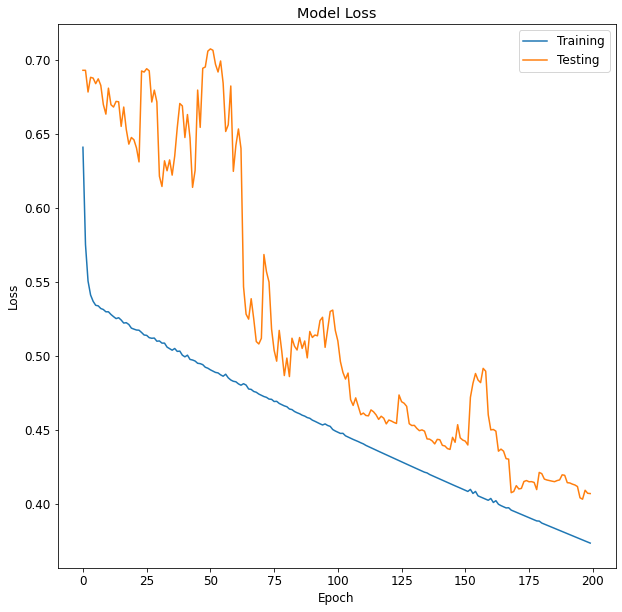

In [51]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('mobilenet_loss.png')
plt.show()